# Fit the resonance as function of flux to extract the josephson participation ratio q_0

In [1]:
import Labber
import numpy as np
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt
from fitTools.Resonator import Resonator
plt.rcParams.update({'font.size':14})

#### insert full path to data file

In [2]:
fpath = r"G:\Shared drives\LFL\Labber\Data\2021\03\Data_0311\NBR07_fluxsweep_TWPA.hdf5"

#### split up the file name and path, then make a directory to save the figures

In [3]:
path,fname = os.path.split(fpath)
path = path + '\\'
fname,ext = fname.split('.')
figpath = 'figures\\'+fname+'\\'
if not os.path.exists(path+'figures\\'):
    os.mkdir(path+'figures\\')
if not os.path.exists(path+figpath):
    os.mkdir(path+figpath)

#### Open the data file with Labber API and extract the number of entries and the flux bias setpoints

In [4]:
lf = Labber.LogFile(path + fname + '.hdf5')
nEntries  = lf.getNumberOfEntries()
FluxBias = np.squeeze(lf.getData(name='Victor - Source current'))

### loop through all flux bias values, fitting the resonance for each VNA trace

In [5]:
from scipy.signal import savgol_filter


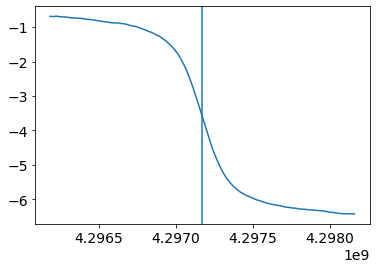

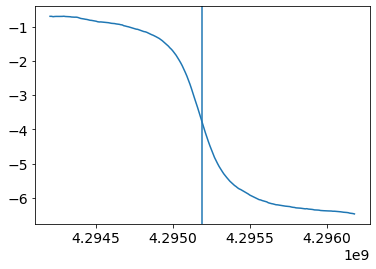

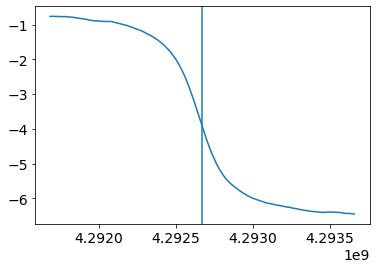

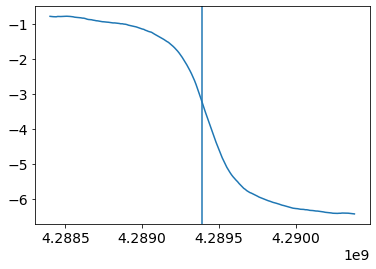

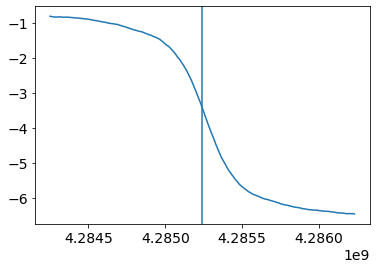

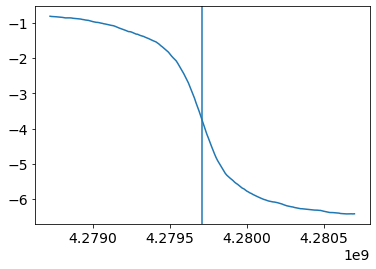

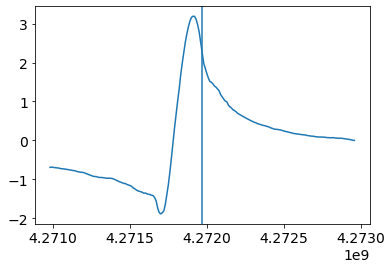

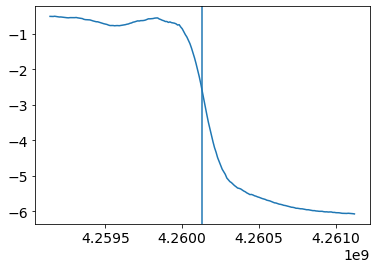

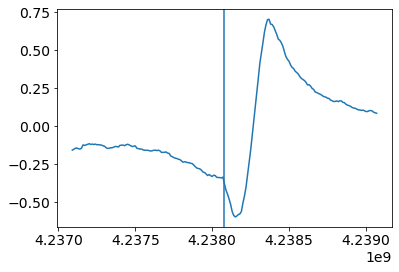

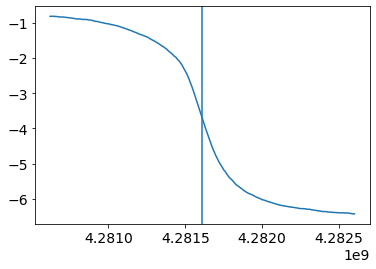

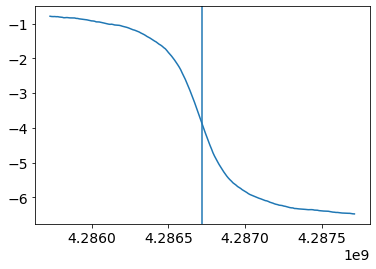

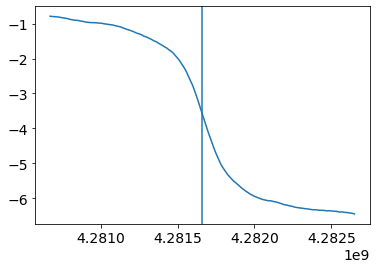

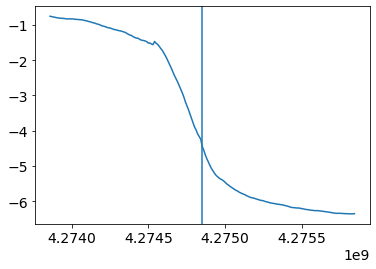

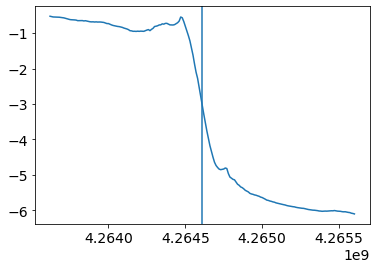

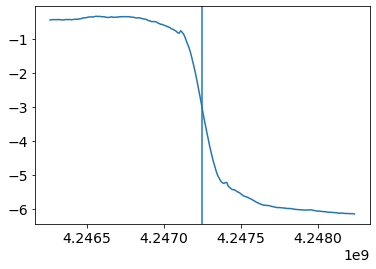

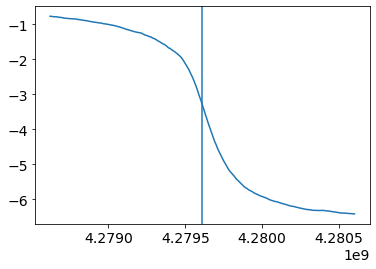

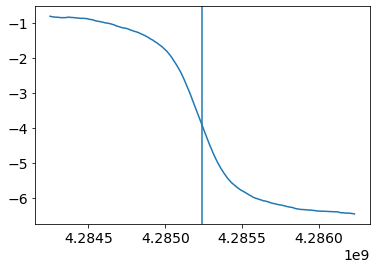

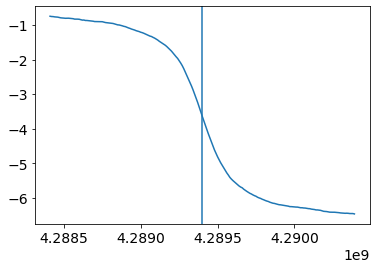

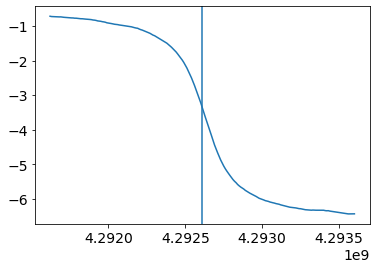

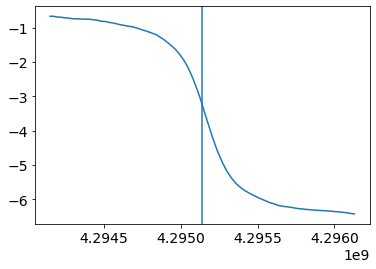

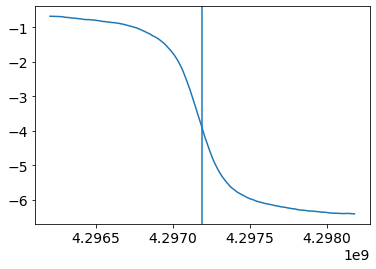

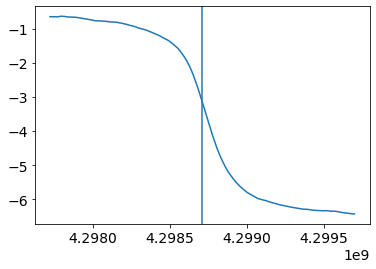

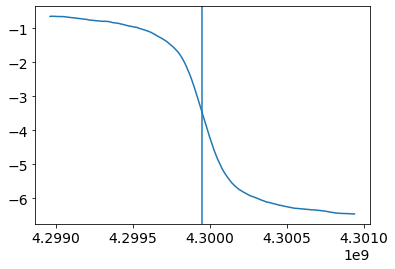

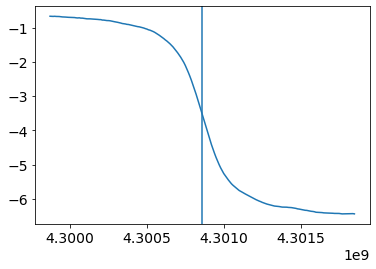

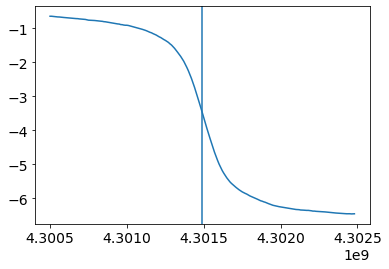

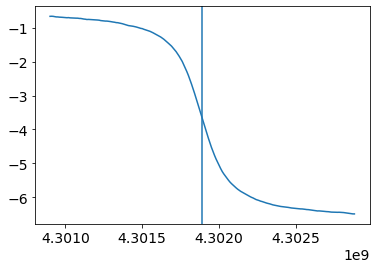

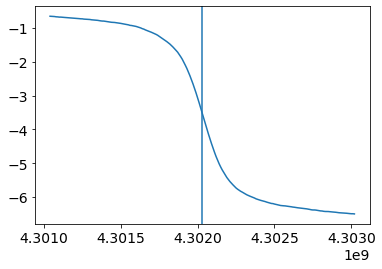

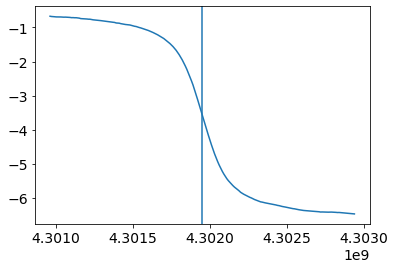

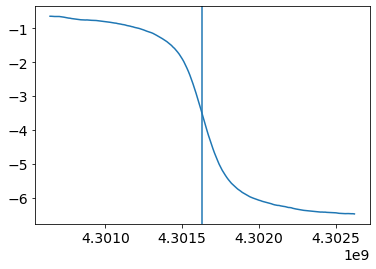

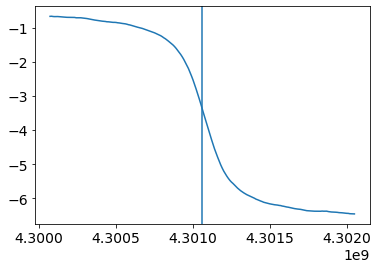

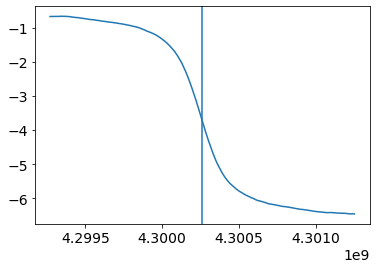

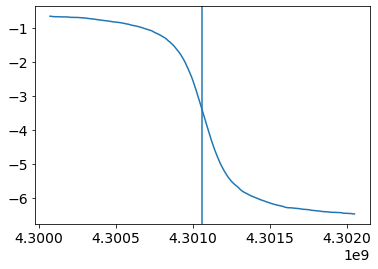

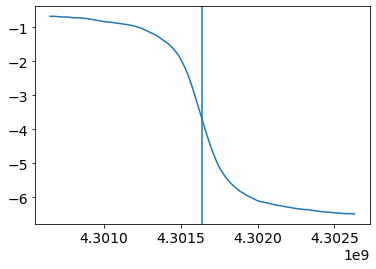

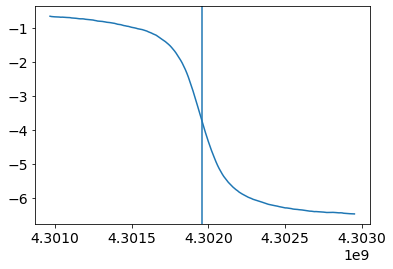

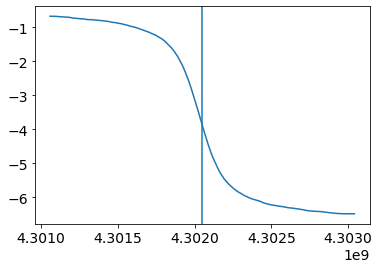

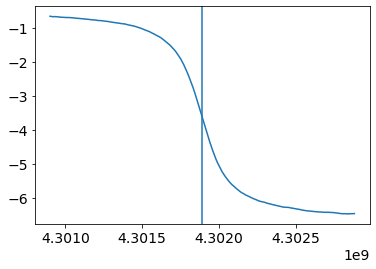

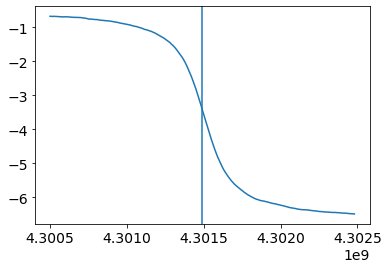

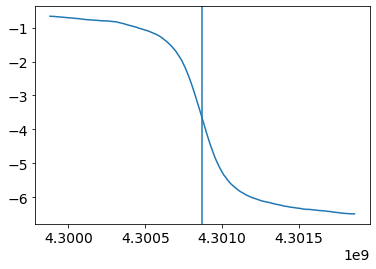

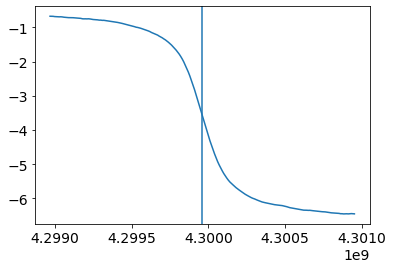

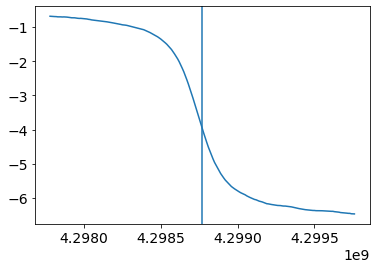

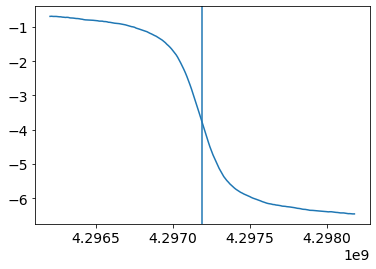

In [6]:
fits = {'f':[],'Q':[],'Qint':[],'Qext':[]}
for n in range(nEntries):
    (xdata,ydata) = lf.getTraceXY(entry = n)
    window = round(len(ydata)*0.003)
    if (window % 2 == 0):
        window += 1       # ensure the window has an odd number of points
    window = max(window, 7)
    ph = savgol_filter(np.unwrap(np.angle(ydata)),window,3)
    dphase = np.gradient(ph,xdata)
    est_f0_ind = np.argmin(dphase)
    est_f0 = xdata[est_f0_ind]
    dmask = np.logical_and(xdata > est_f0-1e6, xdata < est_f0+1e6)
    plt.plot(xdata[dmask],ph[dmask])
    plt.axvline(x=est_f0)
    plt.show()
    plt.close()
    fits['f'].append(est_f0*1e-9)
#     res = Resonator('r',xdata,ydata)
# #     res = Resonator(xdata,ydata,fit_all=False)
#     res.autofit(fcrop=(est_f0*1e-9-0.001,est_f0*1e-9+0.001))
#     fits['f'].append(res.f0*1e-9)
#     fits['Q'].append(res.Q)
#     fits['Qint'].append(res.Qi)
#     fits['Qext'].append(res.Qc)
#     fits['f'].append(res.location*1e-9)
#     fits['Q'].append(res.Q)
#     fits['Qint'].append(res.get_qint())
#     fits['Qext'].append(res.get_qext())
#     if res.fit_found:
#         res.show(savefile = path+figpath+fname+'trace_{}.png'.format(n))
#         print('fit results for bias {:.3}\n'.format(FluxBias[n]*1e3))
#         print(res)


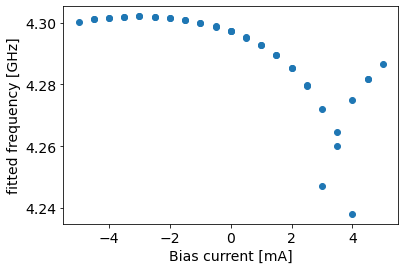

In [7]:
fig1 = plt.Figure(figsize=[9,7],constrained_layout=True);
plt.scatter(FluxBias*1e3,fits['f']);
plt.ylabel('fitted frequency [GHz]');
plt.xlabel('Bias current [mA]');
plt.savefig(path+figpath+"freqVflux.png")

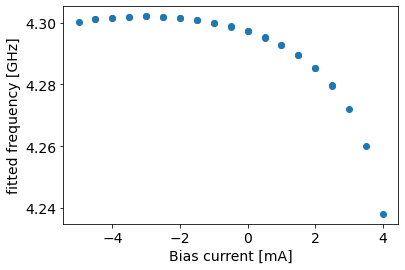

In [8]:
ff = np.array(fits['f'])
mask = np.ones(nEntries,dtype=bool)
mask[9:15] = False
fig1 = plt.Figure(figsize=[9,7],constrained_layout=True);
plt.scatter(FluxBias[mask]*1e3,ff[mask]);
plt.ylabel('fitted frequency [GHz]');
plt.xlabel('Bias current [mA]');

In [19]:
def multiFluxFunc(fl,w0,q0,fl0,fs):
    return w0*(1-q0*(-1+1/np.cos(np.pi*(fl-fl0)/fs))/2)
#                np.sin(np.pi*(fl-fl0)/fs/2)*np.arctanh(np.sin(np.pi*(fl-fl0)/fs/2))/(1-np.sin(np.pi*(fl-fl0)/fs/2)*np.arctanh(np.sin(np.pi*(fl-fl0)/fs/2))))**(-0.5)

def FluxFunc(fl,q0):
    return 1-q0*(-1+1/np.cos(np.pi*fl))/2
#             q0*np.sin(np.pi*fl/2)*np.arctanh(np.sin(np.pi*fl/2))/(1-np.sin(np.pi*fl/2)*np.arctanh(np.sin(np.pi*fl/2))))**(-0.5)

f0 = 4.302 GHz, q0 = 0.01116, zero flux bias = -3.22 mA, phi-scale = 17.55 mA/phi0


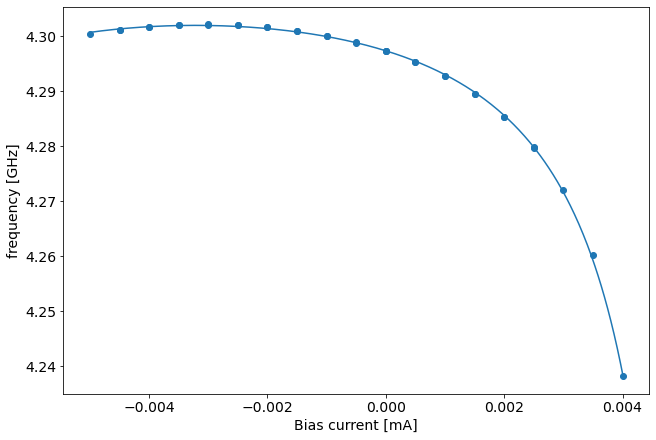

In [20]:
flux_zeros = []
fs = -3.2e-3
#for i in range(len(fits['f'])//step):
fig = plt.figure(figsize=[9,6],constrained_layout=True)

subfreqs = ff[mask]
subFlux = FluxBias[mask]
#    plt.scatter(subFlux,subfreqs)
pars,cov = curve_fit(multiFluxFunc,subFlux,np.asarray(subfreqs)*2e9*np.pi,p0=[2*np.pi*4.3e9,0.011,fs,17e-3])
print('f0 = {:.4} GHz, q0 = {:.4}, zero flux bias = {:.4} mA, phi-scale = {:.4} mA/phi0'.format(pars[0]/2e9/np.pi,pars[1],pars[2]*1e3,pars[3]*1e3))
flux_zeros.append(pars[-2])
plt.scatter(subFlux,subfreqs)
x = np.linspace(subFlux.min(),subFlux.max(),500)
plt.plot(x,multiFluxFunc(x,*pars)/2e9/np.pi)
plt.xlabel('Bias current [mA]')
plt.ylabel('frequency [GHz]')
plt.savefig(path+figpath+fname+'_multiFluxFit_tunnelCPR.png')

In [60]:
# phiscale = pars[3]
# phiscale = 0.013811024473154536
phiscale = 15e-3
# f0 = pars[0]/2e9/np.pi
# fzero = -3.1e-3

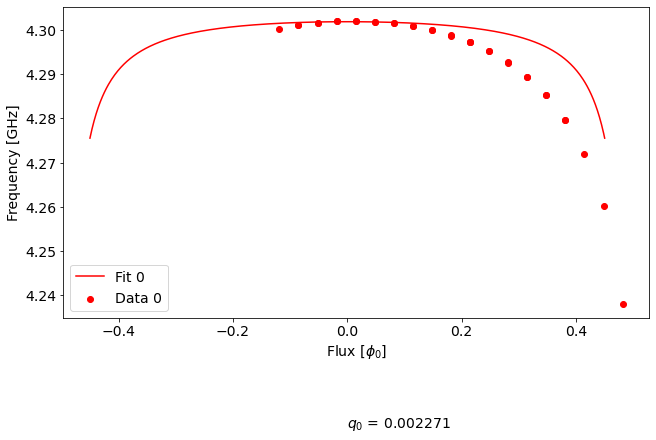

In [61]:
colors = ['r','b','g','o','k','cyan']
lw = []
lq0 = []
fig = plt.figure(figsize=[9,6],constrained_layout=True)
masks = [mask]
fl = FluxBias
for i in range(1):
    w = ff[masks[i]]/f0
    subFlux = fl[masks[i]]
    fzero = flux_zeros[i]
    PHI = (subFlux - fzero)/phiscale
    p0 = [0.01]
    pars,cov = curve_fit(FluxFunc,PHI,w,p0=p0,bounds=(0,0.5))
    lq0.append(pars[0])
    x = np.linspace(-0.45,0.45,500)
    ffit = FluxFunc(x,*pars)*f0
    plt.scatter(PHI,w*f0,c=colors[i],label='Data {}'.format(i))
    plt.plot(x,ffit,colors[i],label='Fit {}'.format(i))
plt.xlabel('Flux [$\phi_0$]')
plt.ylabel('Frequency [GHz]')
plt.legend()
plt.text(0,4.21,'$q_0$ = {:.4}'.format(np.mean(lq0)))
plt.savefig(path+figpath+fname+'_f0-vs-flux_tunnelCPR.png')
plt.show()

In [62]:
pars

array([0.00227099])

In [63]:
print('zero flux = {:.5}\nhalf flux = {:.5}'.format(FluxFunc(0.0,*pars)*f0,FluxFunc(0.45,*pars)*f0))

zero flux = 4.3019
half flux = 4.2755


In [64]:
print('participation ratio = {:.4}'.format(np.mean(lq0)))

participation ratio = 0.002271


In [65]:
f0qp = 4.26865e9

In [66]:
FluxFunc(0.45,*pars)*f0

4.2755304356580925

In [67]:
q0 = np.mean(lq0)
L0 = 1.816
Lmeas=1.84982
qterm = q0/(1-q0)
for i in range(10):
    Ls = qterm*L0
    L0 = Lmeas - Ls
    print('L = {:.6}, Ls = {:.6}'.format(L0,Ls))

L = 1.84569, Ls = 0.0041335
L = 1.84562, Ls = 0.00420107
L = 1.84562, Ls = 0.00420091
L = 1.84562, Ls = 0.00420091
L = 1.84562, Ls = 0.00420091
L = 1.84562, Ls = 0.00420091
L = 1.84562, Ls = 0.00420091
L = 1.84562, Ls = 0.00420091
L = 1.84562, Ls = 0.00420091
L = 1.84562, Ls = 0.00420091
